In [68]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.stem.porter import PorterStemmer
import numpy as np
import torch
from matplotlib import pyplot as plt
%matplotlib inline
print(torch.cuda.is_available())

True


In [116]:
#ファイル入力
def file_input(input_path,output_path):
    with open(input_path,encoding='UTF-8-sig') as f:
        s = f.read()
    s = s.strip().replace('\t','\n').replace('.','')
    sentences = s.split('\n')
    ps = PorterStemmer()
    for i in range(len(sentences)):
        token = sentences[i].split(' ')
        singles = [ps.stem(plural) for plural in token]
        #sentences[i] = token
        sentences[i] = singles
    return sentences

In [31]:
# 単語IDの登録
def word_to_id(sentences:list):
    word_id_list = {}
    id_count = 0
    for sentence in sentences:
        for token in sentence:
            if(token not in word_id_list):        
                word_id_list[token] = id_count
                id_count += 1
    return word_id_list

In [137]:
def sub_char(sentences:list):
    new_sentenes = []
    for sentence in sentences:
        new_sentence = []
        for word in sentence:
            w = word.replace(':','').replace(';','').replace('(','').replace(')','').replace(',','').replace('.','')
            new_sentence.append(w)
        new_sentenes.append(new_sentence)
    return new_sentenes

In [33]:
def get_n_gram(sentences:list):
    ngrams = []
    for sentence in sentences:
        l = len(sentence)
        for i in range(l-2):
            list = [sentence[i],sentence[i+2]]
            ngrams.append((list,sentence[i+1]))
    return ngrams

In [34]:
class CBOW(torch.nn.Module):
    def __init__(self,vocab_size,embedding_dim,context_size):
        super(CBOW,self).__init__()
        self.embeddings = torch.nn.Embedding(vocab_size,embedding_dim)
        self.linear1 = torch.nn.Linear(context_size*embedding_dim,128)
        self.linear2 = torch.nn.Linear(128,vocab_size)

    def forward(self,inputs):
        embeds = self.embeddings(inputs).view(1,-1)
        out = torch.nn.functional.relu(self.linear1(embeds))
        out = self.linear2(out)
        return out

In [140]:

input_path = '../train_data/STS.input.OnWN.txt'
#input_path = '../test_data/testinput.txt'
output_path = './output/STS.output.images.tt'
#output_path = './output/testoutput.txt'
# nltk.download('stopwords')
# stopwords = nltk.corpus.stopwords.words('english')

#ファイル入力
sentences = file_input(input_path,output_path)
# sentences = sentences[0:2]
#print(sentences)
sentences = sub_char(sentences)
#print(sentences)

word_to_ix = word_to_id(sentences)
vocab_size = len(word_to_ix)
print(vocab_size)

ngrams = get_n_gram(sentences)
#print(ngrams)

# x,y = create_contexts_target(sentences)
# random.shuffle(x)
# random.shuffle(y)
# vocab_size = len(x)
# print(vocab_size)

1945


In [36]:
# #device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# #torch.set_default_tensor_type('torch.cuda.FloatTensor')
# CONTEXT_SIZE = 2
# EMBEDDING_DIM = 10

# losses = []
# loss_function = torch.nn.CrossEntropyLoss()
# model = CBOW(vocab_size,EMBEDDING_DIM,CONTEXT_SIZE)
# optimizer = torch.optim.SGD(model.parameters(),lr=0.001)
# for epoch in range(400):
#     total_loss = torch.Tensor([0])
#     for context,target in ngrams:
#         context_idxs = [word_to_ix[w] for w in context]
#         # print(context_idxs)
#         context_var = torch.autograd.Variable(torch.LongTensor(context_idxs))
#         # print(context_var)
#         model.zero_grad()
#         output = model(context_var)
#         loss = loss_function(output,torch.autograd.Variable(torch.LongTensor([word_to_ix[target]])))
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.data
#     losses.append(total_loss.detach().numpy()[0])
#     print(epoch,total_loss)

In [141]:
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.set_default_tensor_type('torch.cuda.FloatTensor')
CONTEXT_SIZE = 2
EMBEDDING_DIM = 16
EPOCH_SIZE = 400

losses = []
epochs = []
loss_function = torch.nn.CrossEntropyLoss()
model = CBOW(vocab_size,EMBEDDING_DIM,CONTEXT_SIZE).to('cuda')
#model.load_state_dict(torch.load(PATH))
optimizer = torch.optim.SGD(model.parameters(),lr=0.001)
for epoch in range(EPOCH_SIZE):
    total_loss = torch.Tensor([0])
    for context,target in ngrams:
        context_idxs = [word_to_ix[w] for w in context]
        # print(context_idxs)
        # context_var = torch.autograd.Variable(torch.LongTensor(context_idxs)).to(device)
        context_var = torch.autograd.Variable(torch.LongTensor(context_idxs)).to('cuda')
        # print(context_var)
        model.zero_grad()
        #output = model(context_var)
        output = model(context_var)
        loss = loss_function(output,torch.autograd.Variable(torch.LongTensor([word_to_ix[target]])).to('cuda'))
        loss.backward()
        optimizer.step()
        total_loss += loss.data
    #losses.append(total_loss.cpu().detach().numpy()[0])
    total_loss.to('cpu')
    losses.append(total_loss.item())
    epochs.append(epoch)
    #losses.append(total_loss.detach().numpy()[0])
    print(epoch,total_loss.item())
    PATH = './models2/' + f'model_{epoch}'
    torch.save(model.state_dict(),PATH)

0 56264.00390625
1 47904.9609375
2 45296.1953125
3 43883.6875
4 42819.73828125
5 41884.421875
6 41031.03515625
7 40231.8359375
8 39468.73828125
9 38731.328125
10 38016.67578125
11 37321.078125
12 36642.04296875
13 35974.85546875
14 35316.9140625
15 34668.02734375
16 34028.828125
17 33398.69921875
18 32777.29296875
19 32164.21875
20 31558.662109375
21 30960.685546875
22 30371.16796875
23 29790.10546875
24 29217.451171875
25 28653.171875
26 28097.919921875
27 27552.201171875
28 27015.38671875
29 26488.978515625
30 25973.111328125
31 25468.0
32 24972.953125
33 24488.34765625
34 24014.439453125
35 23551.748046875
36 23099.283203125
37 22657.28515625
38 22226.4609375
39 21806.2109375
40 21396.609375
41 20997.54296875
42 20608.64453125
43 20230.30859375
44 19861.73046875
45 19502.7734375
46 19153.9453125
47 18814.126953125
48 18484.349609375
49 18164.3515625
50 17853.78515625
51 17552.66796875
52 17260.55078125
53 16977.55078125
54 16703.697265625
55 16438.52734375
56 16181.2119140625
57 159

odict_keys(['embeddings.weight', 'linear1.weight', 'linear1.bias', 'linear2.weight', 'linear2.bias'])
torch.Size([1945, 16])
1945
tensor([[-0.2696,  0.6276,  0.8817,  ...,  0.5424,  0.7958, -1.0809],
        [-1.0296, -0.3061, -0.3854,  ..., -2.9485, -0.8930,  0.6146],
        [-0.1708, -1.4095, -0.3011,  ..., -0.8280,  0.9732, -1.0896],
        ...,
        [ 0.0954, -0.3435, -0.7074,  ..., -1.3365,  0.4130, -0.7168],
        [-0.1502, -0.1133, -1.9500,  ..., -0.1781, -0.8255, -0.4022],
        [ 0.6179,  0.4679,  1.0955,  ..., -1.6650,  0.6565, -1.5967]])


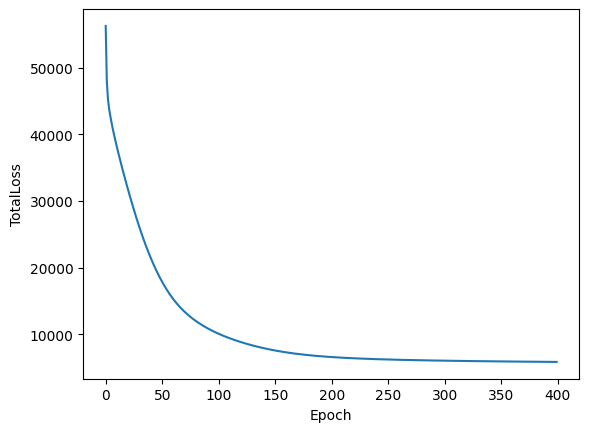

In [142]:
state_dict = model.state_dict()
print(state_dict.keys())
w = state_dict['embeddings.weight']
w.size()
print(w.size())
print(vocab_size)
print(w)

x = [i for i in range(EPOCH_SIZE)]
#print(x)
#print(losses)
plt.plot(x,losses)
plt.xlabel('Epoch')
plt.ylabel('TotalLoss')
plt.savefig('./output/graph2.png')
plt.show()


In [143]:
import pickle
with open('./output/vocab2.pkl','wb') as f:
    pickle.dump(word_to_ix,f)

print(word_to_ix)

{'the': 0, 'activ': 1, 'of': 2, 'learn': 3, 'or': 4, 'be': 5, 'train': 6, 'gradual': 7, 'process': 8, 'acquir': 9, 'knowledg': 10, 'thin': 11, 'metal': 12, 'strip': 13, 'use': 14, 'in': 15, 'typeset': 16, 'to': 17, 'separ': 18, 'line': 19, 'type': 20, 'print': 21, 'falcon': 22, 'abandon': 23, 'intend': 24, 'game': 25, 'and': 26, 'pursu': 27, 'lesser': 28, 'prey': 29, 'turn': 30, 'an': 31, 'inferior': 32, 'act': 33, 'design': 34, 'a': 35, 'role': 36, 'someon': 37, 'identifi': 38, 'someth': 39, 'make': 40, 'pure': 41, 'free': 42, 'from': 43, 'sin': 44, 'guilt': 45, 'leav': 46, 'undon': 47, 'out': 48, 'fail': 49, 'do': 50, 'something': 51, 'social': 52, 'set': 53, 'cliqu': 54, 'friend': 55, 'unoffici': 56, 'associ': 57, 'peopl': 58, 'group': 59, 'upper': 60, 'part': 61, 'column': 62, 'that': 63, 'support': 64, 'entablatur': 65, 'sink': 66, 'lower': 67, 'level': 68, 'descend': 69, 'form': 70, 'depress': 71, 'creat': 72, 'code': 73, 'comput': 74, 'program': 75, 'write': 76, 'releas': 77, 'c

In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# import numpy as np
# import urllib.request
# from nltk.tokenize import RegexpTokenizer
# from nltk.corpus import stopwords
# from nltk import word_tokenize
# import sklearn
# from sklearn.cluster import KMeans
# from sklearn.metrics.pairwise import euclidean_distances

# torch.manual_seed(1)

# CONTEXT_SIZE = 3
# EMBEDDING_DIM = 10

# test_sentence = """Empathy for the poor may not come easily to people who never experienced it. They may blame the victims and insist their predicament can be overcome through determination and hard work.
# But they may not realize that extreme poverty can be psychologically and physically incapacitating — a perpetual cycle of bad diets, health care and education exacerbated by the shaming and self-fulfilling prophecies that define it in the public imagination.
# Gordon Parks — perhaps more than any artist — saw poverty as “the most savage of all human afflictions” and realized the power of empathy to help us understand it. It was neither an abstract problem nor political symbol, but something he endured growing up destitute in rural Kansas and having spent years documenting poverty throughout the world, including the United States.
# That sensitivity informed “Freedom’s Fearful Foe: Poverty,” his celebrated photo essay published in Life magazine in June 1961. He took readers into the lives of a Brazilian boy, Flavio da Silva, and his family, who lived in the ramshackle Catacumba favela in the hills outside Rio de Janeiro. These stark photographs are the subject of a new book, “Gordon Parks: The Flavio Story” (Steidl/The Gordon Parks Foundation), which accompanies a traveling exhibition co-organized by the Ryerson Image Centre in Toronto, where it opens this week, and the J. Paul Getty Museum. Edited with texts by the exhibition’s co-curators, Paul Roth and Amanda Maddox, the book also includes a recent interview with Mr. da Silva and essays by Beatriz Jaguaribe, Maria Alice Rezende de Carvalho and Sérgio Burgi.
# """.split()
# # we should tokenize the input, but we will ignore that for now
# # build a list of tuples.  Each tuple is ([ word_i-2, word_i-1 ], target word)

# #print(test_sentence)
# print(len(test_sentence))
# def get_key(word_id):
#     for key,val in word_to_ix.items():
#         if(val == word_id):
#             print(key)

# def cluster_embeddings(filename,nclusters):
#     X = np.load(filename)
#     kmeans = KMeans(n_clusters=nclusters, random_state=0).fit(X)
#     center = kmeans.cluster_centers_
#     distances = euclidean_distances(X,center)

#     for i in np.arange(0,distances.shape[1]):
#         word_id = np.argmin(distances[:,i])
#         print(word_id)
#         get_key(word_id)

# def read_data(file_path):
#     tokenizer = RegexpTokenizer(r'\w+')
#     data = urllib.request.urlopen(file_path)
#     data = data.read().decode('utf8')
#     tokenized_data = word_tokenize(data)
#     stop_words = set(stopwords.words('english'))
#     stop_words.update(['.',',',':',';','(',')','#','--','...','"'])
#     cleaned_words = [ i for i in tokenized_data if i not in stop_words ]
#     return(cleaned_words)

# #test_sentence = read_data('https://www.gutenberg.org/files/57884/57884-0.txt')

# ngrams = []
# for i in range(len(test_sentence) - CONTEXT_SIZE):
#     tup = [test_sentence[j] for j in np.arange(i , i + CONTEXT_SIZE) ]
#     ngrams.append((tup,test_sentence[i + CONTEXT_SIZE]))
# # print the first 3, just so you can see what they look like
# print(ngrams)


# vocab = set(test_sentence)
# print(vocab)
# print("Length of vocabulary",len(vocab))
# word_to_ix = {word: i for i, word in enumerate(vocab)}
# print(word_to_ix)


# class CBOWModeler(nn.Module):

#     def __init__(self, vocab_size, embedding_dim, context_size):
#         super(CBOWModeler, self).__init__()
#         self.embeddings = nn.Embedding(vocab_size, embedding_dim)
#         self.linear1 = nn.Linear(context_size * embedding_dim, 128)
#         self.linear2 = nn.Linear(128, vocab_size)

#     def forward(self, inputs):
#         embeds = self.embeddings(inputs).view((1, -1))  # -1 implies size inferred for that index from the size of the data
#         #print(np.mean(np.mean(self.linear2.weight.data.numpy())))
#         out1 = F.relu(self.linear1(embeds)) # output of first layer
#         out2 = self.linear2(out1)           # output of second layer
#         #print(embeds)
#         log_probs = F.log_softmax(out2, dim=1)
#         return log_probs

#     def predict(self,input):
#         context_idxs = torch.tensor([word_to_ix[w] for w in input], dtype=torch.long)
#         res = self.forward(context_idxs)
#         res_arg = torch.argmax(res)
#         res_val, res_ind = res.sort(descending=True)
#         res_val = res_val[0][:3]
#         res_ind = res_ind[0][:3]
#         #print(res_val)
#         #print(res_ind)
#         for arg in zip(res_val,res_ind):
#             #print(arg)
#             print([(key,val,arg[0]) for key,val in word_to_ix.items() if val == arg[1]])

#     def freeze_layer(self,layer):
#         for name,child in model.named_children():
#             print(name,child)
#             if(name == layer):
#                 for names,params in child.named_parameters():
#                     print(names,params)
#                     print(params.size())
#                     params.requires_grad= False

#     def print_layer_parameters(self):
#         for name,child in model.named_children():
#                 print(name,child)
#                 for names,params in child.named_parameters():
#                     print(names,params)
#                     print(params.size())

#     def write_embedding_to_file(self,filename):
#         for i in self.embeddings.parameters():
#             weights = i.data.numpy()
#         np.save(filename,weights)



# losses = []
# loss_function = nn.NLLLoss()
# model = CBOWModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
# optimizer = optim.SGD(model.parameters(), lr=0.001)

# # Freeze embedding layer
# #model.freeze_layer('embeddings')


# for epoch in range(400):
#     total_loss = 0
#     #------- Embedding layers are trained as well here ----#
#     #lookup_tensor = torch.tensor([word_to_ix["poor"]], dtype=torch.long)
#     #hello_embed = model.embeddings(lookup_tensor)
#     #print(hello_embed)
#     # -----------------------------------------------------#

#     for context, target in ngrams:

#         # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
#         # into integer indices and wrap them in tensors)
#         context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
#         #print("Context id",context_idxs)

#         # Step 2. Recall that torch *accumulates* gradients. Before passing in a
#         # new instance, you need to zero out the gradients from the old
#         # instance
#         model.zero_grad()

#         # Step 3. Run the forward pass, getting log probabilities over next
#         # words
#         print(epoch)
#         print(context_idxs)
#         log_probs = model(context_idxs)
#         #print(log_probs)

#         # Step 4. Compute your loss function. (Again, Torch wants the target
#         # word wrapped in a tensor)
#         loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))
#         #print(loss)

#         # Step 5. Do the backward pass and update the gradient
#         loss.backward()
#         optimizer.step()

#         # Get the Python number from a 1-element Tensor by calling tensor.item()
#         total_loss += loss.item()
#     print(total_loss)
#     losses.append(total_loss)
# #print(losses)  # The loss decreased every iteration over the training data!

# #Print the model layer parameters
# #model.print_layer_parameters()

# #Predict the next word given n context words
# model.predict(['of','all','human'])
# model.write_embedding_to_file('embeddings.npy')
# cluster_embeddings('embeddings.npy',2)

10
tensor([146,  40, 149])
10
tensor([ 40, 149, 118])
10
tensor([149, 118,  85])
10
tensor([118,  85,   5])
10
tensor([85,  5, 96])
10
tensor([  5,  96, 180])
10
tensor([ 96, 180, 158])
10
tensor([180, 158, 104])
10
tensor([158, 104,  10])
10
tensor([104,  10,  96])
10
tensor([ 10,  96, 180])
10
tensor([ 96, 180, 189])
10
tensor([180, 189, 187])
10
tensor([189, 187, 165])
10
tensor([187, 165, 177])
10
tensor([165, 177,  54])
10
tensor([177,  54,  43])
10
tensor([ 54,  43, 166])
10
tensor([ 43, 166,  79])
10
tensor([166,  79,  94])
10
tensor([ 79,  94, 180])
10
tensor([ 94, 180, 192])
10
tensor([180, 192,  49])
10
tensor([192,  49, 117])
10
tensor([ 49, 117, 151])
10
tensor([117, 151, 171])
10
tensor([151, 171, 108])
10
tensor([171, 108, 119])
10
tensor([108, 119, 144])
10
tensor([119, 144,  76])
10
tensor([144,  76, 152])
10
tensor([ 76, 152,  71])
10
tensor([152,  71,  18])
10
tensor([71, 18, 87])
10
tensor([18, 87, 15])
10
tensor([ 87,  15, 125])
10
tensor([ 15, 125,  73])
10
tensor(

12
tensor([178,  40, 153])
12
tensor([ 40, 153, 132])
12
tensor([153, 132,  86])
12
tensor([132,  86, 117])
12
tensor([ 86, 117,  37])
12
tensor([117,  37,  13])
12
tensor([37, 13, 49])
12
tensor([ 13,  49, 142])
12
tensor([ 49, 142, 193])
12
tensor([142, 193, 102])
12
tensor([193, 102, 181])
12
tensor([102, 181,  40])
12
tensor([181,  40,   1])
12
tensor([40,  1,  4])
12
tensor([ 1,  4, 35])
12
tensor([  4,  35, 180])
12
tensor([ 35, 180,  63])
12
tensor([180,  63,  40])
12
tensor([63, 40, 75])
12
tensor([40, 75, 28])
12
tensor([75, 28, 48])
12
tensor([ 28,  48, 106])
12
tensor([ 48, 106, 133])
12
tensor([106, 133,  96])
12
tensor([133,  96, 180])
12
tensor([ 96, 180, 169])
12
tensor([180, 169,  89])
12
tensor([169,  89,  18])
12
tensor([89, 18, 87])
12
tensor([18, 87, 86])
12
tensor([87, 86, 98])
12
tensor([ 86,  98, 105])
12
tensor([ 98, 105, 139])
12
tensor([105, 139,  70])
12
tensor([139,  70,  51])
12
tensor([70, 51, 86])
12
tensor([ 51,  86, 112])
12
tensor([ 86, 112, 186])
12
t

13
tensor([180, 189, 187])
13
tensor([189, 187, 165])
13
tensor([187, 165, 177])
13
tensor([165, 177,  54])
13
tensor([177,  54,  43])
13
tensor([ 54,  43, 166])
13
tensor([ 43, 166,  79])
13
tensor([166,  79,  94])
13
tensor([ 79,  94, 180])
13
tensor([ 94, 180, 192])
13
tensor([180, 192,  49])
13
tensor([192,  49, 117])
13
tensor([ 49, 117, 151])
13
tensor([117, 151, 171])
13
tensor([151, 171, 108])
13
tensor([171, 108, 119])
13
tensor([108, 119, 144])
13
tensor([119, 144,  76])
13
tensor([144,  76, 152])
13
tensor([ 76, 152,  71])
13
tensor([152,  71,  18])
13
tensor([71, 18, 87])
13
tensor([18, 87, 15])
13
tensor([ 87,  15, 125])
13
tensor([ 15, 125,  73])
13
tensor([125,  73, 117])
13
tensor([ 73, 117, 161])
13
tensor([117, 161, 109])
13
tensor([161, 109,  99])
13
tensor([109,  99,  35])
13
tensor([ 99,  35, 180])
13
tensor([ 35, 180, 115])
13
tensor([180, 115,  39])
13
tensor([115,  39, 111])
13
tensor([ 39, 111,  96])
13
tensor([111,  96, 122])
13
tensor([ 96, 122,  30])
13
tens

15
tensor([153, 132,  86])
15
tensor([132,  86, 117])
15
tensor([ 86, 117,  37])
15
tensor([117,  37,  13])
15
tensor([37, 13, 49])
15
tensor([ 13,  49, 142])
15
tensor([ 49, 142, 193])
15
tensor([142, 193, 102])
15
tensor([193, 102, 181])
15
tensor([102, 181,  40])
15
tensor([181,  40,   1])
15
tensor([40,  1,  4])
15
tensor([ 1,  4, 35])
15
tensor([  4,  35, 180])
15
tensor([ 35, 180,  63])
15
tensor([180,  63,  40])
15
tensor([63, 40, 75])
15
tensor([40, 75, 28])
15
tensor([75, 28, 48])
15
tensor([ 28,  48, 106])
15
tensor([ 48, 106, 133])
15
tensor([106, 133,  96])
15
tensor([133,  96, 180])
15
tensor([ 96, 180, 169])
15
tensor([180, 169,  89])
15
tensor([169,  89,  18])
15
tensor([89, 18, 87])
15
tensor([18, 87, 86])
15
tensor([87, 86, 98])
15
tensor([ 86,  98, 105])
15
tensor([ 98, 105, 139])
15
tensor([105, 139,  70])
15
tensor([139,  70,  51])
15
tensor([70, 51, 86])
15
tensor([ 51,  86, 112])
15
tensor([ 86, 112, 186])
15
tensor([112, 186, 188])
15
tensor([186, 188,  93])
15
t

16
tensor([ 49, 117, 151])
16
tensor([117, 151, 171])
16
tensor([151, 171, 108])
16
tensor([171, 108, 119])
16
tensor([108, 119, 144])
16
tensor([119, 144,  76])
16
tensor([144,  76, 152])
16
tensor([ 76, 152,  71])
16
tensor([152,  71,  18])
16
tensor([71, 18, 87])
16
tensor([18, 87, 15])
16
tensor([ 87,  15, 125])
16
tensor([ 15, 125,  73])
16
tensor([125,  73, 117])
16
tensor([ 73, 117, 161])
16
tensor([117, 161, 109])
16
tensor([161, 109,  99])
16
tensor([109,  99,  35])
16
tensor([ 99,  35, 180])
16
tensor([ 35, 180, 115])
16
tensor([180, 115,  39])
16
tensor([115,  39, 111])
16
tensor([ 39, 111,  96])
16
tensor([111,  96, 122])
16
tensor([ 96, 122,  30])
16
tensor([122,  30, 133])
16
tensor([ 30, 133,  55])
16
tensor([133,  55,  16])
16
tensor([55, 16, 45])
16
tensor([16, 45, 40])
16
tensor([ 45,  40, 180])
16
tensor([ 40, 180, 173])
16
tensor([180, 173,   0])
16
tensor([173,   0,  65])
16
tensor([  0,  65, 150])
16
tensor([ 65, 150,  74])
16
tensor([150,  74, 129])
16
tensor([ 7

18
tensor([142, 193, 102])
18
tensor([193, 102, 181])
18
tensor([102, 181,  40])
18
tensor([181,  40,   1])
18
tensor([40,  1,  4])
18
tensor([ 1,  4, 35])
18
tensor([  4,  35, 180])
18
tensor([ 35, 180,  63])
18
tensor([180,  63,  40])
18
tensor([63, 40, 75])
18
tensor([40, 75, 28])
18
tensor([75, 28, 48])
18
tensor([ 28,  48, 106])
18
tensor([ 48, 106, 133])
18
tensor([106, 133,  96])
18
tensor([133,  96, 180])
18
tensor([ 96, 180, 169])
18
tensor([180, 169,  89])
18
tensor([169,  89,  18])
18
tensor([89, 18, 87])
18
tensor([18, 87, 86])
18
tensor([87, 86, 98])
18
tensor([ 86,  98, 105])
18
tensor([ 98, 105, 139])
18
tensor([105, 139,  70])
18
tensor([139,  70,  51])
18
tensor([70, 51, 86])
18
tensor([ 51,  86, 112])
18
tensor([ 86, 112, 186])
18
tensor([112, 186, 188])
18
tensor([186, 188,  93])
18
tensor([188,  93, 156])
18
tensor([ 93, 156, 127])
18
tensor([156, 127,  49])
18
tensor([127,  49,  88])
18
tensor([ 49,  88, 194])
18
tensor([ 88, 194, 160])
18
tensor([194, 160,  40])
1

19
tensor([ 40, 149, 118])
19
tensor([149, 118,  85])
19
tensor([118,  85,   5])
19
tensor([85,  5, 96])
19
tensor([  5,  96, 180])
19
tensor([ 96, 180, 158])
19
tensor([180, 158, 104])
19
tensor([158, 104,  10])
19
tensor([104,  10,  96])
19
tensor([ 10,  96, 180])
19
tensor([ 96, 180, 189])
19
tensor([180, 189, 187])
19
tensor([189, 187, 165])
19
tensor([187, 165, 177])
19
tensor([165, 177,  54])
19
tensor([177,  54,  43])
19
tensor([ 54,  43, 166])
19
tensor([ 43, 166,  79])
19
tensor([166,  79,  94])
19
tensor([ 79,  94, 180])
19
tensor([ 94, 180, 192])
19
tensor([180, 192,  49])
19
tensor([192,  49, 117])
19
tensor([ 49, 117, 151])
19
tensor([117, 151, 171])
19
tensor([151, 171, 108])
19
tensor([171, 108, 119])
19
tensor([108, 119, 144])
19
tensor([119, 144,  76])
19
tensor([144,  76, 152])
19
tensor([ 76, 152,  71])
19
tensor([152,  71,  18])
19
tensor([71, 18, 87])
19
tensor([18, 87, 15])
19
tensor([ 87,  15, 125])
19
tensor([ 15, 125,  73])
19
tensor([125,  73, 117])
19
tensor(

21
tensor([40, 17, 11])
21
tensor([ 17,  11, 143])
21
tensor([ 11, 143, 138])
21
tensor([143, 138,  80])
21
tensor([138,  80,  66])
21
tensor([ 80,  66, 154])
21
tensor([ 66, 154,  48])
21
tensor([154,  48,  84])
21
tensor([ 48,  84, 186])
21
tensor([ 84, 186,  47])
21
tensor([186,  47, 183])
21
tensor([ 47, 183, 178])
21
tensor([183, 178,  40])
21
tensor([178,  40, 153])
21
tensor([ 40, 153, 132])
21
tensor([153, 132,  86])
21
tensor([132,  86, 117])
21
tensor([ 86, 117,  37])
21
tensor([117,  37,  13])
21
tensor([37, 13, 49])
21
tensor([ 13,  49, 142])
21
tensor([ 49, 142, 193])
21
tensor([142, 193, 102])
21
tensor([193, 102, 181])
21
tensor([102, 181,  40])
21
tensor([181,  40,   1])
21
tensor([40,  1,  4])
21
tensor([ 1,  4, 35])
21
tensor([  4,  35, 180])
21
tensor([ 35, 180,  63])
21
tensor([180,  63,  40])
21
tensor([63, 40, 75])
21
tensor([40, 75, 28])
21
tensor([75, 28, 48])
21
tensor([ 28,  48, 106])
21
tensor([ 48, 106, 133])
21
tensor([106, 133,  96])
21
tensor([133,  96, 1

22
tensor([ 49, 117,  46])
22
tensor([117,  46,  59])
22
tensor([46, 59, 76])
22
tensor([59, 76,  3])
22
tensor([ 76,   3, 146])
22
tensor([  3, 146,  40])
22
tensor([146,  40, 149])
22
tensor([ 40, 149, 118])
22
tensor([149, 118,  85])
22
tensor([118,  85,   5])
22
tensor([85,  5, 96])
22
tensor([  5,  96, 180])
22
tensor([ 96, 180, 158])
22
tensor([180, 158, 104])
22
tensor([158, 104,  10])
22
tensor([104,  10,  96])
22
tensor([ 10,  96, 180])
22
tensor([ 96, 180, 189])
22
tensor([180, 189, 187])
22
tensor([189, 187, 165])
22
tensor([187, 165, 177])
22
tensor([165, 177,  54])
22
tensor([177,  54,  43])
22
tensor([ 54,  43, 166])
22
tensor([ 43, 166,  79])
22
tensor([166,  79,  94])
22
tensor([ 79,  94, 180])
22
tensor([ 94, 180, 192])
22
tensor([180, 192,  49])
22
tensor([192,  49, 117])
22
tensor([ 49, 117, 151])
22
tensor([117, 151, 171])
22
tensor([151, 171, 108])
22
tensor([171, 108, 119])
22
tensor([108, 119, 144])
22
tensor([119, 144,  76])
22
tensor([144,  76, 152])
22
tensor(

24
tensor([ 27,  44, 137])
24
tensor([ 44, 137,  47])
24
tensor([137,  47, 183])
24
tensor([ 47, 183,  41])
24
tensor([183,  41,  25])
24
tensor([ 41,  25, 184])
24
tensor([ 25, 184,  40])
24
tensor([184,  40,  17])
24
tensor([40, 17, 11])
24
tensor([ 17,  11, 143])
24
tensor([ 11, 143, 138])
24
tensor([143, 138,  80])
24
tensor([138,  80,  66])
24
tensor([ 80,  66, 154])
24
tensor([ 66, 154,  48])
24
tensor([154,  48,  84])
24
tensor([ 48,  84, 186])
24
tensor([ 84, 186,  47])
24
tensor([186,  47, 183])
24
tensor([ 47, 183, 178])
24
tensor([183, 178,  40])
24
tensor([178,  40, 153])
24
tensor([ 40, 153, 132])
24
tensor([153, 132,  86])
24
tensor([132,  86, 117])
24
tensor([ 86, 117,  37])
24
tensor([117,  37,  13])
24
tensor([37, 13, 49])
24
tensor([ 13,  49, 142])
24
tensor([ 49, 142, 193])
24
tensor([142, 193, 102])
24
tensor([193, 102, 181])
24
tensor([102, 181,  40])
24
tensor([181,  40,   1])
24
tensor([40,  1,  4])
24
tensor([ 1,  4, 35])
24
tensor([  4,  35, 180])
24
tensor([ 3

25
tensor([190, 110,  58])
25
tensor([110,  58, 101])
25
tensor([ 58, 101, 180])
25
tensor([101, 180, 103])
25
tensor([180, 103,  49])
25
tensor([103,  49, 117])
25
tensor([ 49, 117,  46])
25
tensor([117,  46,  59])
25
tensor([46, 59, 76])
25
tensor([59, 76,  3])
25
tensor([ 76,   3, 146])
25
tensor([  3, 146,  40])
25
tensor([146,  40, 149])
25
tensor([ 40, 149, 118])
25
tensor([149, 118,  85])
25
tensor([118,  85,   5])
25
tensor([85,  5, 96])
25
tensor([  5,  96, 180])
25
tensor([ 96, 180, 158])
25
tensor([180, 158, 104])
25
tensor([158, 104,  10])
25
tensor([104,  10,  96])
25
tensor([ 10,  96, 180])
25
tensor([ 96, 180, 189])
25
tensor([180, 189, 187])
25
tensor([189, 187, 165])
25
tensor([187, 165, 177])
25
tensor([165, 177,  54])
25
tensor([177,  54,  43])
25
tensor([ 54,  43, 166])
25
tensor([ 43, 166,  79])
25
tensor([166,  79,  94])
25
tensor([ 79,  94, 180])
25
tensor([ 94, 180, 192])
25
tensor([180, 192,  49])
25
tensor([192,  49, 117])
25
tensor([ 49, 117, 151])
25
tensor(

27
tensor([12, 40, 27])
27
tensor([40, 27, 44])
27
tensor([ 27,  44, 137])
27
tensor([ 44, 137,  47])
27
tensor([137,  47, 183])
27
tensor([ 47, 183,  41])
27
tensor([183,  41,  25])
27
tensor([ 41,  25, 184])
27
tensor([ 25, 184,  40])
27
tensor([184,  40,  17])
27
tensor([40, 17, 11])
27
tensor([ 17,  11, 143])
27
tensor([ 11, 143, 138])
27
tensor([143, 138,  80])
27
tensor([138,  80,  66])
27
tensor([ 80,  66, 154])
27
tensor([ 66, 154,  48])
27
tensor([154,  48,  84])
27
tensor([ 48,  84, 186])
27
tensor([ 84, 186,  47])
27
tensor([186,  47, 183])
27
tensor([ 47, 183, 178])
27
tensor([183, 178,  40])
27
tensor([178,  40, 153])
27
tensor([ 40, 153, 132])
27
tensor([153, 132,  86])
27
tensor([132,  86, 117])
27
tensor([ 86, 117,  37])
27
tensor([117,  37,  13])
27
tensor([37, 13, 49])
27
tensor([ 13,  49, 142])
27
tensor([ 49, 142, 193])
27
tensor([142, 193, 102])
27
tensor([193, 102, 181])
27
tensor([102, 181,  40])
27
tensor([181,  40,   1])
27
tensor([40,  1,  4])
27
tensor([ 1,  

28
tensor([ 96, 162,  61])
28
tensor([162,  61,  96])
28
tensor([ 61,  96, 121])
28
tensor([ 96, 121,  83])
28
tensor([121,  83, 190])
28
tensor([ 83, 190, 110])
28
tensor([190, 110,  58])
28
tensor([110,  58, 101])
28
tensor([ 58, 101, 180])
28
tensor([101, 180, 103])
28
tensor([180, 103,  49])
28
tensor([103,  49, 117])
28
tensor([ 49, 117,  46])
28
tensor([117,  46,  59])
28
tensor([46, 59, 76])
28
tensor([59, 76,  3])
28
tensor([ 76,   3, 146])
28
tensor([  3, 146,  40])
28
tensor([146,  40, 149])
28
tensor([ 40, 149, 118])
28
tensor([149, 118,  85])
28
tensor([118,  85,   5])
28
tensor([85,  5, 96])
28
tensor([  5,  96, 180])
28
tensor([ 96, 180, 158])
28
tensor([180, 158, 104])
28
tensor([158, 104,  10])
28
tensor([104,  10,  96])
28
tensor([ 10,  96, 180])
28
tensor([ 96, 180, 189])
28
tensor([180, 189, 187])
28
tensor([189, 187, 165])
28
tensor([187, 165, 177])
28
tensor([165, 177,  54])
28
tensor([177,  54,  43])
28
tensor([ 54,  43, 166])
28
tensor([ 43, 166,  79])
28
tensor(

30
tensor([ 41,  25, 184])
30
tensor([ 25, 184,  40])
30
tensor([184,  40,  17])
30
tensor([40, 17, 11])
30
tensor([ 17,  11, 143])
30
tensor([ 11, 143, 138])
30
tensor([143, 138,  80])
30
tensor([138,  80,  66])
30
tensor([ 80,  66, 154])
30
tensor([ 66, 154,  48])
30
tensor([154,  48,  84])
30
tensor([ 48,  84, 186])
30
tensor([ 84, 186,  47])
30
tensor([186,  47, 183])
30
tensor([ 47, 183, 178])
30
tensor([183, 178,  40])
30
tensor([178,  40, 153])
30
tensor([ 40, 153, 132])
30
tensor([153, 132,  86])
30
tensor([132,  86, 117])
30
tensor([ 86, 117,  37])
30
tensor([117,  37,  13])
30
tensor([37, 13, 49])
30
tensor([ 13,  49, 142])
30
tensor([ 49, 142, 193])
30
tensor([142, 193, 102])
30
tensor([193, 102, 181])
30
tensor([102, 181,  40])
30
tensor([181,  40,   1])
30
tensor([40,  1,  4])
30
tensor([ 1,  4, 35])
30
tensor([  4,  35, 180])
30
tensor([ 35, 180,  63])
30
tensor([180,  63,  40])
30
tensor([63, 40, 75])
30
tensor([40, 75, 28])
30
tensor([75, 28, 48])
30
tensor([ 28,  48, 1

31
tensor([159,  96, 162])
31
tensor([ 96, 162,  61])
31
tensor([162,  61,  96])
31
tensor([ 61,  96, 121])
31
tensor([ 96, 121,  83])
31
tensor([121,  83, 190])
31
tensor([ 83, 190, 110])
31
tensor([190, 110,  58])
31
tensor([110,  58, 101])
31
tensor([ 58, 101, 180])
31
tensor([101, 180, 103])
31
tensor([180, 103,  49])
31
tensor([103,  49, 117])
31
tensor([ 49, 117,  46])
31
tensor([117,  46,  59])
31
tensor([46, 59, 76])
31
tensor([59, 76,  3])
31
tensor([ 76,   3, 146])
31
tensor([  3, 146,  40])
31
tensor([146,  40, 149])
31
tensor([ 40, 149, 118])
31
tensor([149, 118,  85])
31
tensor([118,  85,   5])
31
tensor([85,  5, 96])
31
tensor([  5,  96, 180])
31
tensor([ 96, 180, 158])
31
tensor([180, 158, 104])
31
tensor([158, 104,  10])
31
tensor([104,  10,  96])
31
tensor([ 10,  96, 180])
31
tensor([ 96, 180, 189])
31
tensor([180, 189, 187])
31
tensor([189, 187, 165])
31
tensor([187, 165, 177])
31
tensor([165, 177,  54])
31
tensor([177,  54,  43])
31
tensor([ 54,  43, 166])
31
tensor(

33
tensor([ 34, 180,  12])
33
tensor([180,  12,  40])
33
tensor([12, 40, 27])
33
tensor([40, 27, 44])
33
tensor([ 27,  44, 137])
33
tensor([ 44, 137,  47])
33
tensor([137,  47, 183])
33
tensor([ 47, 183,  41])
33
tensor([183,  41,  25])
33
tensor([ 41,  25, 184])
33
tensor([ 25, 184,  40])
33
tensor([184,  40,  17])
33
tensor([40, 17, 11])
33
tensor([ 17,  11, 143])
33
tensor([ 11, 143, 138])
33
tensor([143, 138,  80])
33
tensor([138,  80,  66])
33
tensor([ 80,  66, 154])
33
tensor([ 66, 154,  48])
33
tensor([154,  48,  84])
33
tensor([ 48,  84, 186])
33
tensor([ 84, 186,  47])
33
tensor([186,  47, 183])
33
tensor([ 47, 183, 178])
33
tensor([183, 178,  40])
33
tensor([178,  40, 153])
33
tensor([ 40, 153, 132])
33
tensor([153, 132,  86])
33
tensor([132,  86, 117])
33
tensor([ 86, 117,  37])
33
tensor([117,  37,  13])
33
tensor([37, 13, 49])
33
tensor([ 13,  49, 142])
33
tensor([ 49, 142, 193])
33
tensor([142, 193, 102])
33
tensor([193, 102, 181])
33
tensor([102, 181,  40])
33
tensor([18

34
tensor([159,  96, 162])
34
tensor([ 96, 162,  61])
34
tensor([162,  61,  96])
34
tensor([ 61,  96, 121])
34
tensor([ 96, 121,  83])
34
tensor([121,  83, 190])
34
tensor([ 83, 190, 110])
34
tensor([190, 110,  58])
34
tensor([110,  58, 101])
34
tensor([ 58, 101, 180])
34
tensor([101, 180, 103])
34
tensor([180, 103,  49])
34
tensor([103,  49, 117])
34
tensor([ 49, 117,  46])
34
tensor([117,  46,  59])
34
tensor([46, 59, 76])
34
tensor([59, 76,  3])
34
tensor([ 76,   3, 146])
34
tensor([  3, 146,  40])
34
tensor([146,  40, 149])
34
tensor([ 40, 149, 118])
34
tensor([149, 118,  85])
34
tensor([118,  85,   5])
34
tensor([85,  5, 96])
34
tensor([  5,  96, 180])
34
tensor([ 96, 180, 158])
34
tensor([180, 158, 104])
34
tensor([158, 104,  10])
34
tensor([104,  10,  96])
34
tensor([ 10,  96, 180])
34
tensor([ 96, 180, 189])
34
tensor([180, 189, 187])
34
tensor([189, 187, 165])
34
tensor([187, 165, 177])
34
tensor([165, 177,  54])
34
tensor([177,  54,  43])
34
tensor([ 54,  43, 166])
34
tensor(

35
tensor([ 95, 172, 177])
35
tensor([172, 177,   6])
35
tensor([177,   6,  40])
35
tensor([  6,  40, 164])
1101.9095811843872
36
tensor([ 92,  69, 180])
36
tensor([ 69, 180, 179])
36
tensor([180, 179,  80])
36
tensor([179,  80,  66])
36
tensor([ 80,  66, 141])
36
tensor([ 66, 141, 163])
36
tensor([141, 163,  72])
36
tensor([163,  72,  29])
36
tensor([72, 29, 85])
36
tensor([29, 85, 97])
36
tensor([85, 97, 24])
36
tensor([ 97,  24, 168])
36
tensor([ 24, 168, 134])
36
tensor([168, 134,  80])
36
tensor([134,  80,  34])
36
tensor([ 80,  34, 180])
36
tensor([ 34, 180,  12])
36
tensor([180,  12,  40])
36
tensor([12, 40, 27])
36
tensor([40, 27, 44])
36
tensor([ 27,  44, 137])
36
tensor([ 44, 137,  47])
36
tensor([137,  47, 183])
36
tensor([ 47, 183,  41])
36
tensor([183,  41,  25])
36
tensor([ 41,  25, 184])
36
tensor([ 25, 184,  40])
36
tensor([184,  40,  17])
36
tensor([40, 17, 11])
36
tensor([ 17,  11, 143])
36
tensor([ 11, 143, 138])
36
tensor([143, 138,  80])
36
tensor([138,  80,  66])


37
tensor([ 72, 113,  32])
37
tensor([113,  32, 116])
37
tensor([ 32, 116, 168])
37
tensor([116, 168,  14])
37
tensor([168,  14,   7])
37
tensor([14,  7, 64])
37
tensor([  7,  64, 145])
37
tensor([ 64, 145, 182])
37
tensor([145, 182,   8])
37
tensor([182,   8, 191])
37
tensor([  8, 191,  50])
37
tensor([191,  50,  62])
37
tensor([ 50,  62, 157])
37
tensor([ 62, 157,   2])
37
tensor([157,   2, 100])
37
tensor([  2, 100,  91])
37
tensor([100,  91, 114])
37
tensor([ 91, 114, 175])
37
tensor([114, 175, 140])
37
tensor([175, 140,  96])
37
tensor([140,  96, 170])
37
tensor([ 96, 170, 128])
37
tensor([170, 128,  40])
37
tensor([128,  40,  57])
37
tensor([ 40,  57, 131])
37
tensor([ 57, 131,  52])
37
tensor([131,  52, 147])
37
tensor([ 52, 147, 186])
37
tensor([147, 186,  82])
37
tensor([186,  82, 180])
37
tensor([ 82, 180, 123])
37
tensor([180, 123, 176])
37
tensor([123, 176, 180])
37
tensor([176, 180,  56])
37
tensor([180,  56, 148])
37
tensor([ 56, 148, 135])
37
tensor([148, 135, 174])
37
t

tensor([151, 171, 108])
38
tensor([171, 108, 119])
38
tensor([108, 119, 144])
38
tensor([119, 144,  76])
38
tensor([144,  76, 152])
38
tensor([ 76, 152,  71])
38
tensor([152,  71,  18])
38
tensor([71, 18, 87])
38
tensor([18, 87, 15])
38
tensor([ 87,  15, 125])
38
tensor([ 15, 125,  73])
38
tensor([125,  73, 117])
38
tensor([ 73, 117, 161])
38
tensor([117, 161, 109])
38
tensor([161, 109,  99])
38
tensor([109,  99,  35])
38
tensor([ 99,  35, 180])
38
tensor([ 35, 180, 115])
38
tensor([180, 115,  39])
38
tensor([115,  39, 111])
38
tensor([ 39, 111,  96])
38
tensor([111,  96, 122])
38
tensor([ 96, 122,  30])
38
tensor([122,  30, 133])
38
tensor([ 30, 133,  55])
38
tensor([133,  55,  16])
38
tensor([55, 16, 45])
38
tensor([16, 45, 40])
38
tensor([ 45,  40, 180])
38
tensor([ 40, 180, 173])
38
tensor([180, 173,   0])
38
tensor([173,   0,  65])
38
tensor([  0,  65, 150])
38
tensor([ 65, 150,  74])
38
tensor([150,  74, 129])
38
tensor([ 74, 129,  42])
38
tensor([129,  42,  35])
38
tensor([ 42, 

40
tensor([183, 178,  40])
40
tensor([178,  40, 153])
40
tensor([ 40, 153, 132])
40
tensor([153, 132,  86])
40
tensor([132,  86, 117])
40
tensor([ 86, 117,  37])
40
tensor([117,  37,  13])
40
tensor([37, 13, 49])
40
tensor([ 13,  49, 142])
40
tensor([ 49, 142, 193])
40
tensor([142, 193, 102])
40
tensor([193, 102, 181])
40
tensor([102, 181,  40])
40
tensor([181,  40,   1])
40
tensor([40,  1,  4])
40
tensor([ 1,  4, 35])
40
tensor([  4,  35, 180])
40
tensor([ 35, 180,  63])
40
tensor([180,  63,  40])
40
tensor([63, 40, 75])
40
tensor([40, 75, 28])
40
tensor([75, 28, 48])
40
tensor([ 28,  48, 106])
40
tensor([ 48, 106, 133])
40
tensor([106, 133,  96])
40
tensor([133,  96, 180])
40
tensor([ 96, 180, 169])
40
tensor([180, 169,  89])
40
tensor([169,  89,  18])
40
tensor([89, 18, 87])
40
tensor([18, 87, 86])
40
tensor([87, 86, 98])
40
tensor([ 86,  98, 105])
40
tensor([ 98, 105, 139])
40
tensor([105, 139,  70])
40
tensor([139,  70,  51])
40
tensor([70, 51, 86])
40
tensor([ 51,  86, 112])
40
t

41
tensor([ 76,   3, 146])
41
tensor([  3, 146,  40])
41
tensor([146,  40, 149])
41
tensor([ 40, 149, 118])
41
tensor([149, 118,  85])
41
tensor([118,  85,   5])
41
tensor([85,  5, 96])
41
tensor([  5,  96, 180])
41
tensor([ 96, 180, 158])
41
tensor([180, 158, 104])
41
tensor([158, 104,  10])
41
tensor([104,  10,  96])
41
tensor([ 10,  96, 180])
41
tensor([ 96, 180, 189])
41
tensor([180, 189, 187])
41
tensor([189, 187, 165])
41
tensor([187, 165, 177])
41
tensor([165, 177,  54])
41
tensor([177,  54,  43])
41
tensor([ 54,  43, 166])
41
tensor([ 43, 166,  79])
41
tensor([166,  79,  94])
41
tensor([ 79,  94, 180])
41
tensor([ 94, 180, 192])
41
tensor([180, 192,  49])
41
tensor([192,  49, 117])
41
tensor([ 49, 117, 151])
41
tensor([117, 151, 171])
41
tensor([151, 171, 108])
41
tensor([171, 108, 119])
41
tensor([108, 119, 144])
41
tensor([119, 144,  76])
41
tensor([144,  76, 152])
41
tensor([ 76, 152,  71])
41
tensor([152,  71,  18])
41
tensor([71, 18, 87])
41
tensor([18, 87, 15])
41
tensor(

43
tensor([ 47, 183, 178])
43
tensor([183, 178,  40])
43
tensor([178,  40, 153])
43
tensor([ 40, 153, 132])
43
tensor([153, 132,  86])
43
tensor([132,  86, 117])
43
tensor([ 86, 117,  37])
43
tensor([117,  37,  13])
43
tensor([37, 13, 49])
43
tensor([ 13,  49, 142])
43
tensor([ 49, 142, 193])
43
tensor([142, 193, 102])
43
tensor([193, 102, 181])
43
tensor([102, 181,  40])
43
tensor([181,  40,   1])
43
tensor([40,  1,  4])
43
tensor([ 1,  4, 35])
43
tensor([  4,  35, 180])
43
tensor([ 35, 180,  63])
43
tensor([180,  63,  40])
43
tensor([63, 40, 75])
43
tensor([40, 75, 28])
43
tensor([75, 28, 48])
43
tensor([ 28,  48, 106])
43
tensor([ 48, 106, 133])
43
tensor([106, 133,  96])
43
tensor([133,  96, 180])
43
tensor([ 96, 180, 169])
43
tensor([180, 169,  89])
43
tensor([169,  89,  18])
43
tensor([89, 18, 87])
43
tensor([18, 87, 86])
43
tensor([87, 86, 98])
43
tensor([ 86,  98, 105])
43
tensor([ 98, 105, 139])
43
tensor([105, 139,  70])
43
tensor([139,  70,  51])
43
tensor([70, 51, 86])
43
t

44
tensor([46, 59, 76])
44
tensor([59, 76,  3])
44
tensor([ 76,   3, 146])
44
tensor([  3, 146,  40])
44
tensor([146,  40, 149])
44
tensor([ 40, 149, 118])
44
tensor([149, 118,  85])
44
tensor([118,  85,   5])
44
tensor([85,  5, 96])
44
tensor([  5,  96, 180])
44
tensor([ 96, 180, 158])
44
tensor([180, 158, 104])
44
tensor([158, 104,  10])
44
tensor([104,  10,  96])
44
tensor([ 10,  96, 180])
44
tensor([ 96, 180, 189])
44
tensor([180, 189, 187])
44
tensor([189, 187, 165])
44
tensor([187, 165, 177])
44
tensor([165, 177,  54])
44
tensor([177,  54,  43])
44
tensor([ 54,  43, 166])
44
tensor([ 43, 166,  79])
44
tensor([166,  79,  94])
44
tensor([ 79,  94, 180])
44
tensor([ 94, 180, 192])
44
tensor([180, 192,  49])
44
tensor([192,  49, 117])
44
tensor([ 49, 117, 151])
44
tensor([117, 151, 171])
44
tensor([151, 171, 108])
44
tensor([171, 108, 119])
44
tensor([108, 119, 144])
44
tensor([119, 144,  76])
44
tensor([144,  76, 152])
44
tensor([ 76, 152,  71])
44
tensor([152,  71,  18])
44
tensor(

45
tensor([ 42,  35, 180])
45
tensor([ 35, 180,  36])
45
tensor([180,  36, 107])
45
tensor([ 36, 107,   0])
45
tensor([107,   0, 155])
45
tensor([  0, 155,  40])
45
tensor([155,  40,  68])
45
tensor([40, 68, 23])
45
tensor([ 68,  23, 180])
45
tensor([ 23, 180,   9])
45
tensor([180,   9,  38])
45
tensor([ 9, 38, 53])
45
tensor([ 38,  53, 117])
45
tensor([ 53, 117,  60])
45
tensor([117,  60,  90])
45
tensor([ 60,  90, 129])
45
tensor([ 90, 129,  20])
45
tensor([129,  20,   3])
45
tensor([20,  3, 77])
45
tensor([ 3, 77, 40])
45
tensor([ 77,  40, 130])
45
tensor([ 40, 130,  35])
45
tensor([130,  35, 126])
45
tensor([ 35, 126,  22])
45
tensor([126,  22,  33])
45
tensor([22, 33, 95])
45
tensor([ 33,  95, 172])
45
tensor([ 95, 172, 177])
45
tensor([172, 177,   6])
45
tensor([177,   6,  40])
45
tensor([  6,  40, 164])
1030.260410308838
46
tensor([ 92,  69, 180])
46
tensor([ 69, 180, 179])
46
tensor([180, 179,  80])
46
tensor([179,  80,  66])
46
tensor([ 80,  66, 141])
46
tensor([ 66, 141, 163]

KeyboardInterrupt: 

In [144]:
print(sentences)

[['the', 'activ', 'of', 'learn', 'or', 'be', 'train'], ['the', 'gradual', 'process', 'of', 'acquir', 'knowledg'], ['thin', 'metal', 'strip', 'use', 'in', 'typeset'], ['thin', 'strip', 'of', 'metal', 'use', 'to', 'separ', 'line', 'of', 'type', 'in', 'print'], ['falcon', 'abandon', 'intend', 'game', 'and', 'pursu', 'lesser', 'prey'], ['abandon', 'the', 'intend', 'prey', 'turn', 'and', 'pursu', 'an', 'inferior', 'prey'], ['the', 'act', 'of', 'design', 'a', 'role', 'to', 'someon'], ['the', 'act', 'of', 'design', 'or', 'identifi', 'someth'], ['make', 'pure', 'or', 'free', 'from', 'sin'], ['make', 'pure', 'or', 'free', 'from', 'sin', 'or', 'guilt'], ['leav', 'undon', 'or', 'leav', 'out'], ['fail', 'to', 'do', 'something', 'leav', 'someth', 'undon'], ['a', 'social', 'set', 'or', 'cliqu', 'of', 'friend'], ['an', 'unoffici', 'associ', 'of', 'peopl', 'or', 'group'], ['the', 'upper', 'part', 'of', 'a', 'column'], ['the', 'upper', 'part', 'of', 'a', 'column', 'that', 'support', 'the', 'entablatur'